<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:20px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center>
<h1> Sales Prediction </h1>
</center>
</div>

In [1]:
## Import required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
from sklearn.metrics import mean_squared_error
from numpy import sqrt

import matplotlib.pyplot as plt # basic plotting
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import seaborn as sns # for prettier plots


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scsor 

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
# Read Data from Dataset
sales = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
item = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
item_cat = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
sub = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')

<a id="1."></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h1>1. Exploratroy Data Analysis </h1> </center>
<hr>       
<h3> Data Informations: </h3>   
We have four different files for training and one file for submissions.   
For a better understanding of the relationships between the files, I highlight the keys (the key structure) that connect these files.    
<hr> 
<h4> items.csv </h4>
<ul>
<li> item_name - name of item </li>
<li> <b> <span style="color:red;"> item_id </span> </b> - unique identifier of a product </li>
<li> <b> <span style="color:purple;"> item_category_id </span> </b> - unique identifier of item category </li>
</ul> 
<hr>   
<h4> item_categories.csv </h4>   
<ul>
<li> item_category_name - name of item category </li>
<li> <b> <span style="color:purple;"> item_category_id </span> </b> - unique identifier of item category </li>  
</ul>   
<hr> 
<h4> shops.csv </h4>
<ul>
<li> <b> <span style="color:green;"> shop_id </span> </b> - unique identifier of a shop </li>   
<li> shop_name - name of shop </li>  
</ul>
<hr>  
<h4> sales_train.csv </h4>
<ul>
<li> date - date in format dd/mm/yyyy </li>
<li> date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33 </li>  
<li> <b> <span style="color:green;"> shop_id </span> </b> - unique identifier of a shop </li>
<li> <b> <span style="color:red;"> item_id </span> </b> - unique identifier of a product </li>   
<li> item_price - current price of an item </li>
<li> item_cnt_day - number of products sold. You are predicting a monthly amount of this measure </li>
</ul>
<hr>
<h4> test.csv </h4>
<ul>   
<li> ID - an Id that represents a (Shop, Item) tuple within the test set </li>
<li> <b> <span style="color:green;"> shop_id </span> </b> - unique identifier of a shop </li>
<li> <b> <span style="color:red;"> item_id </span> </b> - unique identifier of a product </li>
</ul>  
</div>

In [3]:
def basic_eda(df):
    print("----------TOP 5 RECORDS--------")
    print(df.head(5))
    print("----------INFO-----------------")
    print(df.info())
    print("----------Describe-------------")
    print(df.describe())
    print("----------Columns--------------")
    print(df.columns)
    print("----------Data Types-----------")
    print(df.dtypes)
    print("-------Missing Values----------")
    print(df.isnull().sum())
    print("-------NULL values-------------")
    print(df.isna().sum())
    print("-----Shape Of Data-------------")
    print(df.shape)
    print("---------Unique Value----------")
    print(df.nunique())

In [4]:
print("=============================Sales Data=============================")
basic_eda(sales)

=============================Sales Data=============================
----------TOP 5 RECORDS--------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
----------

In [5]:
print("=============================Test data=============================")
basic_eda(test)

=============================Test data=============================
----------TOP 5 RECORDS--------
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None
----------Describe-------------
                  ID        shop_id        item_id
count  214200.000000  214200.000000  214200.000000
mean   107099.500000      31.642857   11019.398627
std     61834.358168      17.561933    6252.644590
min         0.000000       2.000000      30.000000
25%     53549.750000      16.000000    5381.500000
50%    107099.500000      34.500000   11203.0000

In [6]:
print("=============================Item Categories=============================")
basic_eda(item_cat)

=============================Item Categories=============================
----------TOP 5 RECORDS--------
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None
----------Describe-------------
       item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.00

In [7]:
print("=============================Items=============================")
basic_eda(item)

=============================Items=============================
----------TOP 5 RECORDS--------
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int

In [8]:
print("=============================Shops=============================")
basic_eda(shops)

=============================Shops=============================
----------TOP 5 RECORDS--------
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None
----------Describe-------------
         shop_id
count  60.000000
mean   29.500000
std    17.464249
min     0.000000
25%    14.750000
50%    29.500000
75%    44.250000
max    59.000000
----------Columns--------------
Index(['shop_name', 'shop_id'], dtype='object')
----------Data Types-----------
shop

In [9]:
print("=============================Sample Submission=============================")
basic_eda(sub)

=============================Sample Submission=============================
----------TOP 5 RECORDS--------
   ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB
None
----------Describe-------------
                  ID  item_cnt_month
count  214200.000000        214200.0
mean   107099.500000             0.5
std     61834.358168             0.0
min         0.000000             0.5
25%     53549.750000             0.5
50%    107099.500000             0.5
75%    160649.250000             0.5
max    214199.000000             0.5
----------Colu

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<h3>📝 What have we got so far? 📝</h3>
<hr>
<ul>
<li>We have 60 shops in our training dataset and 42 shops in our test dataset. </li>
<li> We have 21807 distinct items in our training dataset and 5100 distinct items in our test dataset. </li>
<li>Judging by the mean and maximum values of item_price and item_cnt_day, there are some outliers.</li>
<li> All the shops in our test dataset are also in our training dataset. </li>
<li> 362 items in our test dataset are not included in our training dataset</li>.
    <ul>
    <li>This also means that we do not have the price for these items. </li>
    </ul>
</ul>
<h3>What is our target? </h3>
<hr>
<ul>
<li>We want to predict the number of items sold for November 2015. </li> 
    <ul>
    <li> More specifically, we want to predict the number of items sold for each of the 5100 items in our testing dataset and for each shop that sells these items.
    <li> So we have 214200 different rows (pairs of shop_id and item_id represented by the ID) that need to be predicted. 
    <li> Furthermore, 363 elements are not represented in our train_df. Here we may have to use the category to make some predictions.
    </ul>
</ul>
​
</div>

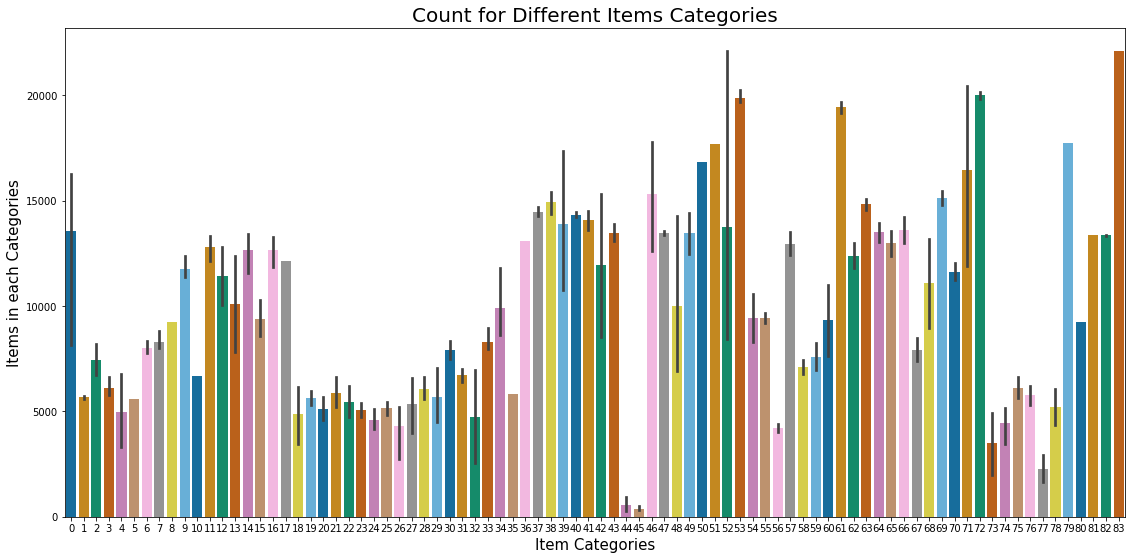

In [10]:
plt.rcParams['figure.figsize'] = (19, 9)
sns.barplot(item['item_category_id'], item['item_id'], palette = 'colorblind')
plt.title('Count for Different Items Categories', fontsize = 20)
plt.xlabel('Item Categories', fontsize = 15)
plt.ylabel('Items in each Categories', fontsize = 15)
plt.show()

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> We can see that most item categories have a wide range of items,and we have diffrent 84 Item Categories in our dataset 
</div>

In [11]:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [12]:
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [13]:
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

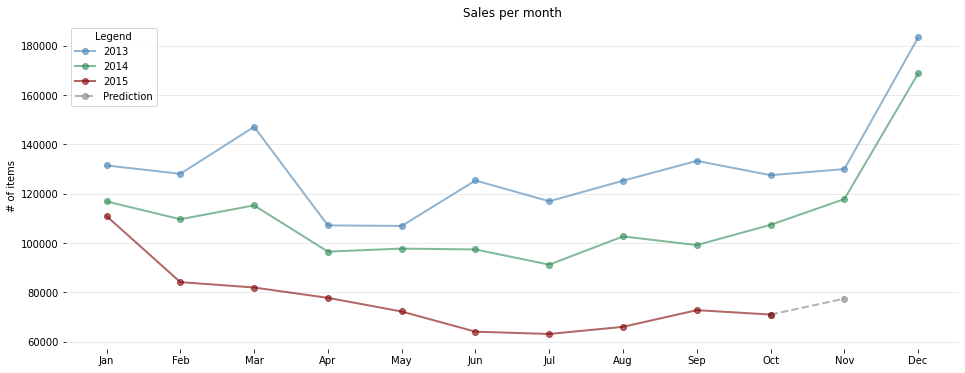

In [14]:
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
LINEWIDTH=2
ALPHA=.6

dfp = sales[['date', 'date_block_num','item_cnt_day']].copy()

# Extract the year and the month from the date column into indepedent columns
dfp['date']  = pd.to_datetime(dfp['date'], format='%d.%m.%Y')
dfp['year']  = dfp['date'].dt.year
dfp['month'] = dfp['date'].dt.month
dfp.drop(['date'], axis=1, inplace=True)

# Sum the number of sold items for each date_block_num (which is the consecutive month number from January 2013 to October 2015)
dfp = dfp.groupby('date_block_num', as_index=False)\
       .agg({'year':'first', 'month':'first', 'item_cnt_day':'sum'})\
       .rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=False)

plt.figure(figsize=(16,6))
# Plot the sales of the year 2013
plt.plot(MONTHS, dfp[dfp.year==2013].item_cnt_month, '-o', color='steelblue', linewidth=LINEWIDTH, alpha=ALPHA,label='2013')

# Plot the sales of the year 2014
plt.plot(MONTHS, dfp[dfp.year==2014].item_cnt_month, '-o', color='seagreen', linewidth=LINEWIDTH, alpha=ALPHA,label='2014')

# Plot the sales of the year 2015 until October
plt.plot(MONTHS[:10], dfp[dfp.year==2015].item_cnt_month, '-o', color='maroon', linewidth=LINEWIDTH, alpha=ALPHA,label='2015')

# Capturing the trend between October and November (For year 2013 and 2014)
delta_2013 = dfp.iloc[10].item_cnt_month - dfp.iloc[9].item_cnt_month
delta_2014 = dfp.iloc[22].item_cnt_month - dfp.iloc[21].item_cnt_month
avg_delta = (delta_2013 + delta_2014) / 2
# Add the average to the previous month (October 2015)
nov_2015 = dfp.iloc[33].item_cnt_month + avg_delta

# MONTHS[9:11] equals ['Oct', 'Nov']
plt.plot(MONTHS[9:11], [dfp.iloc[33].item_cnt_month, nov_2015], '--o', color='gray', linewidth=LINEWIDTH, alpha=ALPHA, label='Prediction', zorder=-1)

# Axes parameters
ax = plt.gca()
ax.set_title('Sales per month')
ax.set_ylabel('# of items')
ax.grid(axis='y', color='gray', alpha=.2)
    
# Remove the frame off the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend(loc=2, title='Legend')
plt.show()

del dfp

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> You can see that sales for 2013 and 2014 are quite similar; At the beggining of the year, they are  decreasing in behaviour and then at last they reached at top. Besides, for year 2015 we have to predict sales for october to november month, which is also highlighed in graph.
</div>

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
          text-align:left">  
📝This has been a long EDA chapter and we have gathered a lot of information on our prediction. Let's summarise what we know, think about what we want 
​
<hr>
<h3>EDA Section Conclusion: 📊😵📉</h3>
<hr>  
    
<h4>So what do we know?</h4>
<ul>
<li>we have multiple items, shops, item categories and associated figures on sales per month.</li>
<li> we took a closer look at the different item categories and found that most of them have their strongest months in November and December.</li>
<li> In addition,we saw that the overall sales show the same picture. So we should expect an increase in sales for november.</li>
</ul>
<hr>
<h4>What do we want?</h4>
<ul>
<li>We want to predict the number of items sold for 214200 different rows (pairs of shop_id and item_id represented by the ID) in our test dataset for November 2015.</li>
</ul>
</div>

<a id="2."></a>
<a id="2.1"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h1> 📜📒✉ --> Time Series Analysis 🏭 --> 📄</h1> </center>
<hr>
A Time Series is nothing but a sequence of various data points that occurred in a successive order for a given period of time.
Time Series Analysis (TSA) is used in different fields for time-based predictions – like Weather Forecasting, Financial, Signal processing, Engineering domain – Control Systems, Communications Systems.
Since TSA involves producing the set of information in a particular sequence, it makes a distinct from spatial and other analyses.
Using AR, MA, ARMA, and ARIMA models, we could predict the future.
<hr>
Components of Time Series Analysis:
<ul>
<li>Trend: In which there is no fixed interval and any divergence within the given dataset is a continuous timeline. The trend would be Negative or Positive or Null Trend</li>
<li>Seasonality: In which regular or fixed interval shifts within the dataset in a continuous timeline. Would be bell curve or saw tooth. </li>
<li>Cyclical: In which there is no fixed interval, uncertainty in movement and its pattern</li>
<li>Irregularity: Unexpected situations/events/scenarios and spikes in a short time span.</li>
</ul>
<hr>
<center> <h3>Data Types of Time Series</h3> </center>    
Let’s discuss the time series’ data types and their influence. 
While discussing TS data-types, there are two major types:
<ul>
    <li>Stationary</li>
    <li>Non- Stationary</li>
</ul>

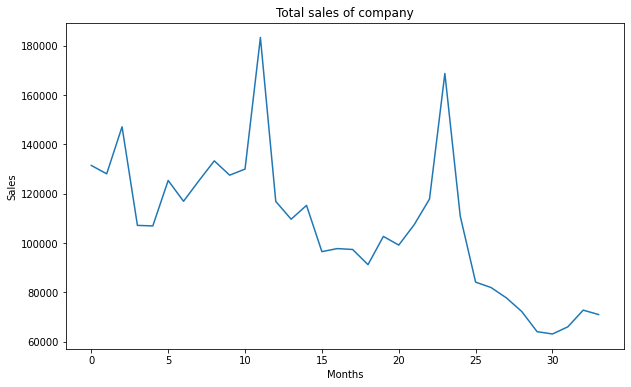

In [15]:
# Group by total monthly sales ...34 months

ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(10,6))
plt.title('Total sales of company')
plt.xlabel('Months')
plt.ylabel('Sales')
indexedDataset = pd.DataFrame(ts)
#indexedDataset.head()
plt.plot(indexedDataset)
plt.show()

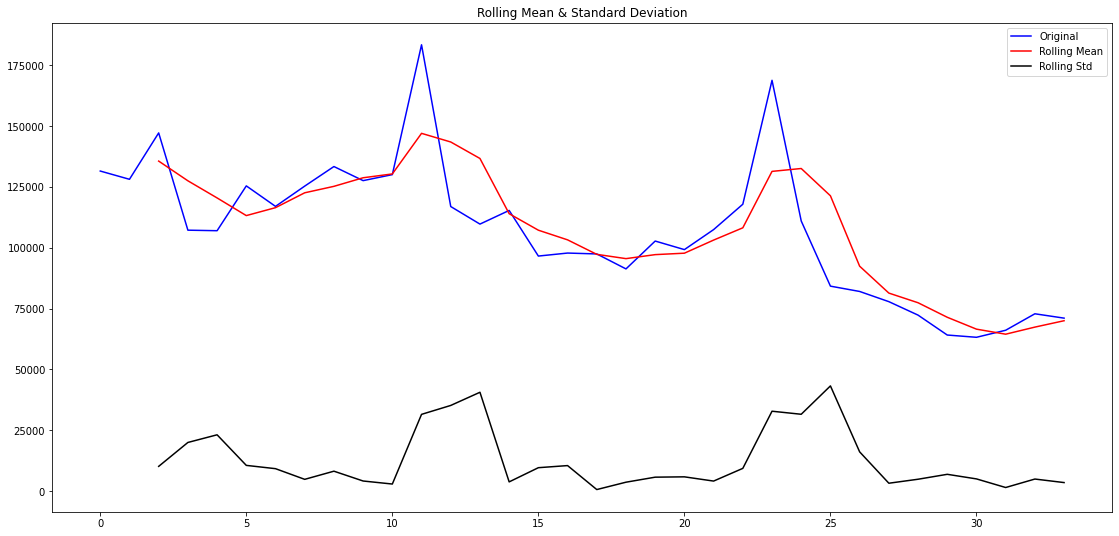

In [16]:
MyWindow = 3
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=MyWindow).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=MyWindow).std()

#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> The Objective required us to predict sales for the next month at a store-item combination.
    Sales over time of sales-item combination is a time series itself.
  <br>
    <b>Quick Observation:</b>There is an obvious "sesonality"(peak sales around a time of year) and a decreasing "Trend".
</div>

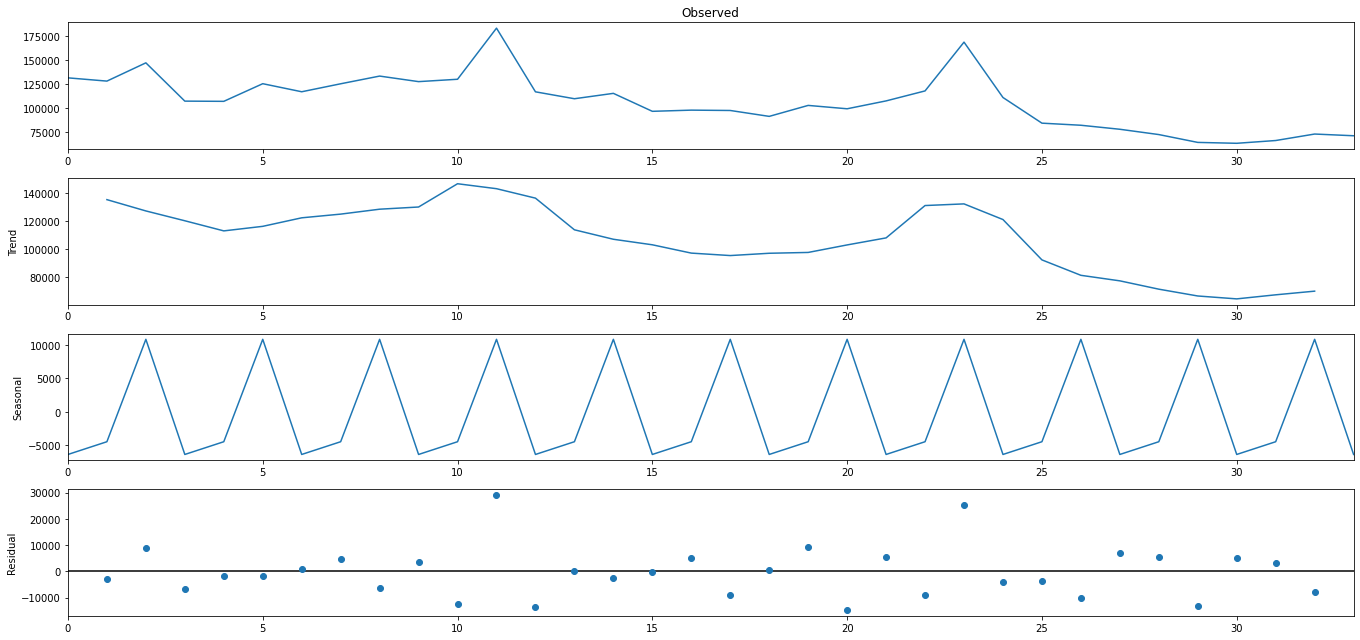

In [17]:
# decompose into trend, seasonality and residuals
res = sm.tsa.seasonal_decompose(indexedDataset.values,period =3,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()

<a id="2."></a>
<a id="2.1"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h3>📜Methods to check Stationarity📒 </h3> </center>
During the TSA model preparation workflow, we must access if the given dataset is Stationary or NOT. Using Statistical and Plots test.
<br>
Statistical Test: There are two tests available to test if the dataset is Stationary or NOT.
<ul>
    <li>Augmented Dickey-Fuller (ADF) Test</li>
    <li>Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test</li>
</ul>
<hr>
📝<b>Augmented Dickey-Fuller (ADF) Test or Unit Root Test:</b> The ADF test is the most popular statistical test and with the following assumptions:
  <ul>
<li>Null Hypothesis (H0): Series is non-stationary</li>
<li>Alternate Hypothesis (HA): Series is stationary</li>
<li>p-value >0.05-----> Fail to reject (H0)</li>
<li>p-value is less then or equal to 0.05-----> Accept (H1) </li>
   </ul>

In [18]:

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> When the test Stastistic is lower than the critical value shown, you assume the null hypothesis and infer that the time series is Statinarity.
    But here Test Statistic value is grater than the critical value and also the P-value obtained is greater than significant level of 0.05.
    Therefore,conclude that The time series is Not stationarity.
</div>

<a id="2."></a>
<a id="2.1"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h3>📜Converting Non- stationary into stationary📒 </h3> </center>
    <hr>
There are two major methods available for this conversion:
<ul>
    <li>Detrending</li>
    <li>Differencing</li>
    <li>Transformation</li>
</ul>
<b>Detrending:</b> It involves removing the trend effects from the given dataset and showing only the differences in values from the trend. it always allows the cyclical patterns to be identified.
<br>
<b>Differencing:</b>This is a simple transformation of the series into a new time series, which we use to remove the series dependence on time and stabilize the mean of the time series, so trend and seasonality are reduced during this transformation.
<br>
<b>Transformation:</b>This includes three different methods they are Power Transform, Square Root, and Log Transfer., most commonly used one is Log Transfer.

In [19]:
from pandas import Series as Series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def inverse_difference(last_ob, value):
    return value + last_ob

[]

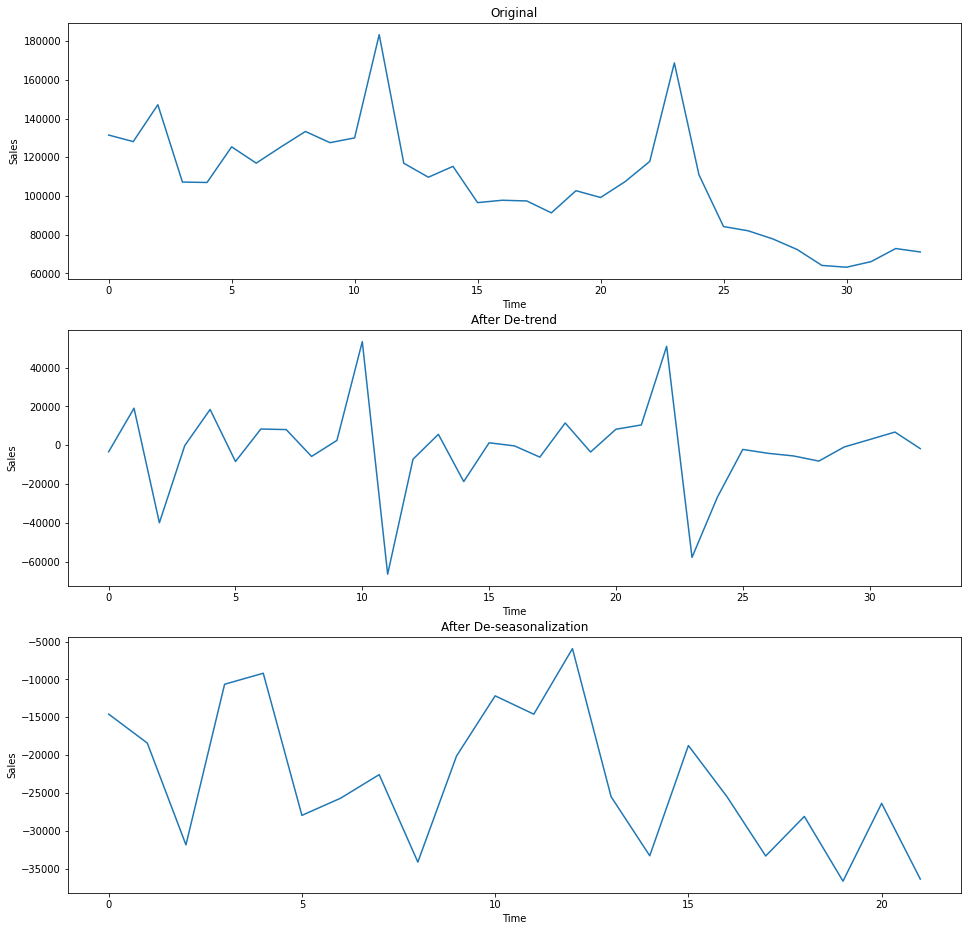

In [20]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       
plt.plot(new_ts)
plt.plot()

In [21]:
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> After the Transformation, P-value for DF test is well within 5%. Hence, We can assume stationarity of the series.
</div>

In [22]:
dataAR = list(indexedDataset.item_cnt_day.values)
len(dataAR)

34

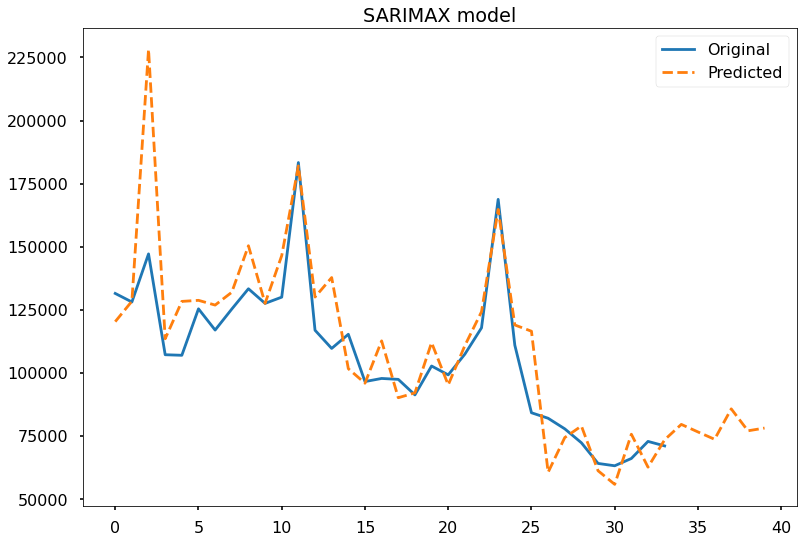

In [23]:
# SARIMA

model = SARIMAX(dataAR, order=(2, 1, 1), seasonal_order=(2,1,1,3))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(1, len(dataAR)+6)

dataList = list(dataAR)
yhatList = list(yhat)

plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList, label='Original')
plt.plot(yhatList, ls='--', label='Predicted')
plt.legend(loc='best')
plt.title('SARIMAX model')
plt.show()

In [24]:
rmse = sqrt(mean_squared_error(dataList,yhatList[0:34]))
print('SARIMA RMSE: %.1f' % rmse)

SARIMA RMSE: 18294.8


In [25]:
grouped_data_df = sales \
    .groupby(['shop_id', 'item_id']) \
    ['date', 'item_cnt_day'] \
    .agg({'item_cnt_day':'sum'})
grouped_data_df.rename(columns={"item_cnt_day": "item_cnt_all"}, inplace=True)
grouped_data_df = grouped_data_df.reset_index()

test['item_cnt_month'] = rmse / len(test) * (len(test)/len(grouped_data_df))
results_df = test.drop(['shop_id', 'item_id'], axis=1)
results_df.to_csv('submission.csv', index=False)
results_df

,ID,item_cnt_month
0,0,0.043135
1,1,0.043135
2,2,0.043135
3,3,0.043135
4,4,0.043135
...,...,...
214195,214195,0.043135
214196,214196,0.043135
214197,214197,0.043135
214198,214198,0.043135
